In [51]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [52]:
bd = pd.read_csv('CVD_cleaned.csv')

In [53]:
bd['Exercise'].replace('No', '0', inplace=True)
bd['Exercise'].replace('Yes', '1', inplace=True)
bd['Exercise'] = bd['Exercise'].astype(int)

bd['Heart_Disease'].replace('No', '0', inplace=True)
bd['Heart_Disease'].replace('Yes', '1', inplace=True)
bd['Heart_Disease'] = bd['Heart_Disease'].astype(int)

bd['Skin_Cancer'].replace('No', '0', inplace=True)
bd['Skin_Cancer'].replace('Yes', '1', inplace=True)
bd['Skin_Cancer'] = bd['Skin_Cancer'].astype(int)

bd['Other_Cancer'].replace('No', '0', inplace=True)
bd['Other_Cancer'].replace('Yes', '1', inplace=True)
bd['Other_Cancer'] = bd['Other_Cancer'].astype(int)

bd['Depression'].replace('No', '0', inplace=True)
bd['Depression'].replace('Yes', '1', inplace=True)
bd['Depression'] = bd['Depression'].astype(int)

bd['Diabetes'].replace('No, pre-diabetes or borderline diabetes', 'No', inplace=True)
bd['Diabetes'].replace('Yes, but female told only during pregnancy', 'Yes', inplace=True)
bd['Diabetes'].replace('No', '0', inplace=True)
bd['Diabetes'].replace('Yes', '1', inplace=True)
bd['Diabetes'] = bd['Diabetes'].astype(int)

bd['Arthritis'].replace('No', '0', inplace=True)
bd['Arthritis'].replace('Yes', '1', inplace=True)
bd['Arthritis'] = bd['Arthritis'].astype(int)

bd['Age_Category'].replace({'18-24' : '18', '25-29' : '25', '30-34' : '30', '35-39' : '35', '40-44' : '40', '45-49' : '45', '50-54' : '50', '55-59' : '55', '60-64' : '60', '65-69' : '65', '70-74' : '70', '75-79' : '75', '80+' : '80'}, inplace=True)
bd['Age_Category'] = bd['Age_Category'].astype(int)

In [54]:
bd['Cancer'] = bd['Skin_Cancer'] + bd['Other_Cancer'] - bd['Skin_Cancer'] * bd['Other_Cancer']

In [56]:
bd.drop(['Alcohol_Consumption', 'Smoking_History', 'Skin_Cancer', 'Other_Cancer'], axis=1, inplace=True)

In [57]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [58]:
target = 'General_Health'
X = bd.drop(columns=[target])
y = bd[target]

In [59]:
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

In [61]:
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
test_pool = Pool(X_test, y_test, cat_features=categorical_columns)

In [62]:
model = CatBoostClassifier(
    iterations=500,       # количество итераций (можно увеличить для лучшего результата)
    learning_rate=0.1,    # скорость обучения
    depth=6,              # глубина деревьев (настраиваемый параметр)
    cat_features=categorical_columns,
    loss_function='MultiClass',  # так как предсказываем категориальную переменную
    eval_metric='Accuracy',      # метрика для оценки
    verbose=100                 # отображение процесса обучения
)

# Обучаем модель
model.fit(train_pool, eval_set=test_pool, verbose=True)

0:	learn: 0.4131081	test: 0.4137216	best: 0.4137216 (0)	total: 804ms	remaining: 6m 41s
1:	learn: 0.4131122	test: 0.4136893	best: 0.4137216 (0)	total: 1.27s	remaining: 5m 17s
2:	learn: 0.4133995	test: 0.4137540	best: 0.4137540 (2)	total: 1.62s	remaining: 4m 29s
3:	learn: 0.4142090	test: 0.4153729	best: 0.4153729 (3)	total: 1.99s	remaining: 4m 6s
4:	learn: 0.4139095	test: 0.4147739	best: 0.4153729 (3)	total: 2.42s	remaining: 3m 59s
5:	learn: 0.4146218	test: 0.4157614	best: 0.4157614 (5)	total: 2.72s	remaining: 3m 44s
6:	learn: 0.4150670	test: 0.4165871	best: 0.4165871 (6)	total: 3.07s	remaining: 3m 36s
7:	learn: 0.4156336	test: 0.4166033	best: 0.4166033 (7)	total: 3.37s	remaining: 3m 26s
8:	learn: 0.4160505	test: 0.4173318	best: 0.4173318 (8)	total: 3.68s	remaining: 3m 20s
9:	learn: 0.4159979	test: 0.4172994	best: 0.4173318 (8)	total: 3.96s	remaining: 3m 14s
10:	learn: 0.4160909	test: 0.4172832	best: 0.4173318 (8)	total: 4.25s	remaining: 3m 8s
11:	learn: 0.4163055	test: 0.4170727	best: 0

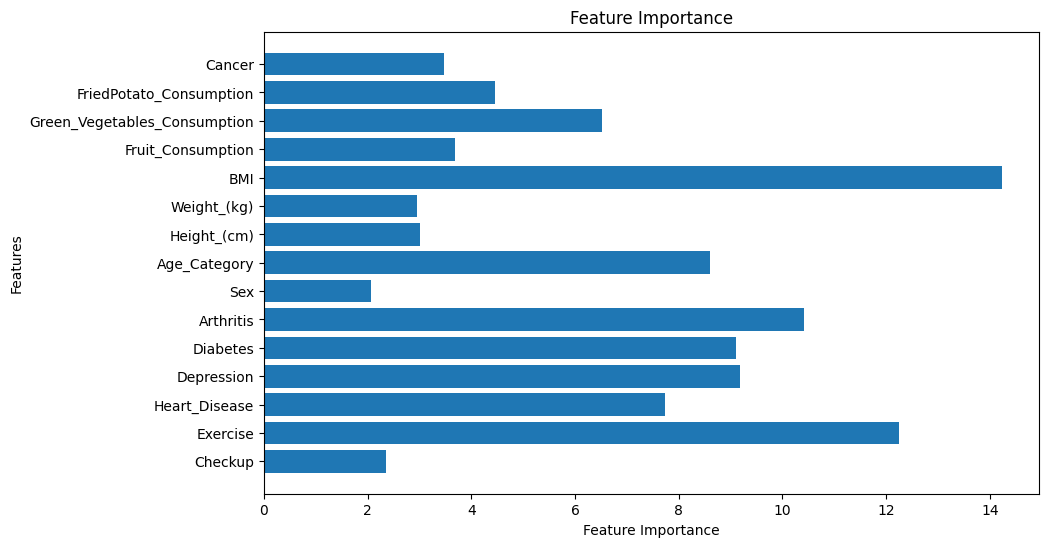

In [63]:
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importances = model.get_feature_importance(train_pool)

# Визуализация важности признаков
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()


In [15]:
bd['General_Health'].value_counts()

General_Health
Very Good    110395
Good          95364
Excellent     55954
Fair          35810
Poor          11331
Name: count, dtype: int64

In [25]:
import shap

# Создание объекта explainer для модели CatBoost
explainer = shap.TreeExplainer(model)

# Рассчитываем значения SHAP для конкретного примера
shap_values = 5

# Предположим, что у вас три класса. Выбираем класс 0 для визуализации.
# Для визуализации определенного класса используем expected_value[0] и shap_values[0]

shap.initjs()

# Визуализация объяснений для класса 0
shap.force_plot(explainer.expected_value[0], shap_values[0], X)


TypeError: 'int' object is not subscriptable

In [17]:
# Проверка количества классов
n_classes = len(shap_values)

# Если хотите визуализировать класс 0:
if n_classes > 0:
    shap.force_plot(explainer.expected_value[0], shap_values[0], X)
else:
    print(f"Ошибка: доступно только {n_classes} классов.")


IndexError: index 5 is out of bounds for axis 0 with size 5

In [23]:
shap_values = explainer.shap_values(X, y)
n_classes = len(shap_values)
print(f"Количество классов: {n_classes}")


Количество классов: 308854


In [24]:
bd['General_Health'].value_counts()

General_Health
Very Good    110395
Good          95364
Excellent     55954
Fair          35810
Poor          11331
Name: count, dtype: int64

In [29]:
import shap

# Создание объекта explainer для модели CatBoost
explainer = shap.TreeExplainer(model)

# Рассчитываем SHAP значения для одной строки данных
X_sample = X.iloc[0:10]  # Взять только первую строку для объяснения
shap_values = explainer.shap_values(X_sample)

# Проверка количества классов (должно быть гораздо меньше 300000)
shap_values


array([[[ 1.91076710e-01, -3.10247950e-02, -1.06946566e-02,
         -2.18794841e-01,  6.94375828e-02],
        [-6.63610152e-01,  3.98545313e-01, -4.61229653e-02,
          8.40445460e-01, -5.29257655e-01],
        [ 7.79920968e-02, -5.43644656e-02,  6.17889367e-03,
         -8.94031037e-02,  5.95965788e-02],
        [ 6.00152172e-04,  7.82808375e-03,  9.07581950e-04,
         -1.59668775e-03, -7.73913012e-03],
        [ 6.91330008e-02, -2.63751671e-02,  8.70835608e-03,
         -9.20365444e-02,  4.05703547e-02],
        [ 1.50444775e-01, -8.82943453e-02,  2.08869447e-02,
         -1.71011589e-01,  8.79742153e-02],
        [ 1.08587367e-01, -8.11120033e-02, -9.71464042e-03,
         -9.39470988e-02,  7.61863753e-02],
        [-6.03624367e-01,  3.24909247e-01, -4.96034466e-02,
          6.12739347e-01, -2.84420780e-01],
        [ 5.54935224e-02, -6.22061668e-02, -5.16142793e-03,
         -7.80782271e-02,  8.99522993e-02],
        [-1.90699015e-01,  1.26175344e-02, -3.28073289e-02,
    

In [64]:
from sklearn.metrics import log_loss
y_pred_proba = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)

print(f"Log Loss: {logloss}")

Log Loss: 1.2459581685671726
